In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import pandas as pd
import psycopg2
import json
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy.stats import skew


# Данные

In [ ]:
path = '/content/drive/MyDrive/solovey/Bundles2023'
files = [i for i in os.listdir(path) if 'Bundles' in i]

In [ ]:
try:
    connection = psycopg2.connect(user="RemoteFA",
                                  database="fa",
                                  password="RFA_127_BT_fandc",
                                  host="rc1b-bdye1rzk75u6dgzf.mdb.yandexcloud.net",
                                  port="6432",
                                  sslmode = "allow")
    cursor = connection.cursor()

except Exception as error:
    print("Ошибка при работе с PostgreSQL", error)

In [ ]:
def make_df(df):
    df.drop('year', axis=1)
    df['first_pub_date'] = pd.to_datetime(df['first_pub_date'])
    df['year'] = df['first_pub_date'].dt.year
    df = df.dropna(subset=['v3_region_index'])
    df = df.dropna(subset=['salary_from_rub'])
    df = df.dropna(subset=['experience_id'])
    df = df.dropna(subset=['group_region'])

    return df

temp = os.path.join(path, files[0])
df = pd.read_csv(temp)
df = make_df(df)

# пункт 4

In [ ]:

def plot_region_group(df):
    grouped = df.groupby('region_name')['salary_from_rub'].mean().reset_index()
    sorted_grouped = grouped.sort_values('salary_from_rub')
    std = sorted_grouped['salary_from_rub'].std()
    groups = []
    lower_bound = sorted_grouped.iloc[0]['salary_from_rub']

    while lower_bound <= sorted_grouped.iloc[-1]['salary_from_rub']:
        upper_bound = lower_bound + std
        group = sorted_grouped[(sorted_grouped['salary_from_rub'] >= lower_bound) & (sorted_grouped['salary_from_rub'] < upper_bound)]
        groups.append(group.region_name.values.tolist())
        lower_bound = upper_bound

    colors = [
        'rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(214, 39, 40)', 'rgb(148, 103, 189)',
        'rgb(140, 86, 75)', 'rgb(227, 119, 194)', 'rgb(127, 127, 127)', 'rgb(188, 189, 34)', 'rgb(23, 190, 207)',
        'rgb(174, 199, 232)', 'rgb(255, 187, 120)', 'rgb(152, 223, 138)', 'rgb(255, 152, 150)', 'rgb(197, 176, 213)',
        'rgb(196, 156, 148)', 'rgb(247, 182, 210)', 'rgb(199, 199, 199)', 'rgb(219, 219, 141)', 'rgb(158, 218, 229)',
        'rgb(203, 213, 232)', 'rgb(255, 185, 120)', 'rgb(169, 221, 161)', 'rgb(255, 152, 150)', 'rgb(226, 187, 210)',
        'rgb(215, 186, 186)', 'rgb(238, 152, 173)', 'rgb(196, 156, 148)', 'rgb(217, 217, 217)', 'rgb(234, 230, 112)',
        'rgb(162, 215, 235)'
    ]

    # Создание словаря с группами и цветами
    group_colors = dict(zip(range(len(groups)), colors))

    # Создание столбца с информацией о группе в датафрейме
    mean_salary_by_region = df.groupby("region_name")["salary_from_rub"].mean().reset_index()
    mean_salary_by_region['group'] = mean_salary_by_region['region_name'].apply(
        lambda x: next((i for i, group in enumerate(groups) if x in group), None)
    )

    mean_salary_by_region.sort_values('salary_from_rub', inplace=True)

    # Построение графика средней зарплаты по регионам, с раскраской по группам
    fig = px.bar(mean_salary_by_region, x="region_name", y="salary_from_rub", color="group",
                labels={'region_name': 'Регион', 'salary_from_rub': 'Средняя зарплата'},
                title='Средняя зарплата по регионам', color_discrete_map=group_colors)

    fig.update_layout(xaxis_tickangle=-45)
    fig.show()


path = '/content/drive/MyDrive/solovey/Bundles2023'
files = [i for i in os.listdir(path) if 'Bundles' in i]
for i in files:
    temp = pd.read_csv(os.path.join(path, i))
    plot_region_group(temp)

In [ ]:
# выведем как выглядит разбиение на группы регионов для всех датафреймов

In [ ]:
path = '/content/drive/MyDrive/solovey/Bundles2023'
files = [i for i in os.listdir(path) if 'Bundles' in i]
for i in files:
    temp = pd.read_csv(os.path.join(path, i))
    temp['group_region']

# пункт 6

первый
6.1. Пересчитать зп для объектов до 2023 года через Z-оценку. Вычислить среднее и стандартное отклонение для каждой подгруппы
И по каждому объекту до 2023 года посчитать:
val_zp/std1*std2-mean1/std1*std2+mean2

где
val_zp - конкретная зарплата по вакансии до 2023 года
std1 - стандартное отклонение подвыборки с соц-дем характеристиками val_zp и тому же году
std2 - стандартное отклонение подвыборки с соц-дем характеристиками val_zp, но по году 2023
mean1 - среднее подвыборки с соц-дем характеристиками val_zp и тому же году
mean2 - среднее подвыборки с соц-дем характеристиками val_zp,  но по году 2023

второй
6.2.
вычислить квентиль для всех значений по каждой подгруппе
Для каждого объекта с val_zp ( конкретная зарплата по вакансии до 2023) определить квентиль текущей подгруппы с соц-дем характеристиками val_zp и тому же году
Заменить значение val_zp значением ближайшего квентиля подгруппы с соц-дем характеристиками val_zp, но 2023 году

# 6 (только квантиль и z-score)

In [ ]:
def draw_new_zp(df):
    old_salaries = df['salary_from_rub']
    new_salaries_z = df['new_salary_z_score']
    new_salaries_q = df['new_salary_quantile']


    sns.kdeplot(data=old_salaries, color='blue', label='Старая зарплата')
    sns.kdeplot(data=new_salaries_z, color='green', label='Новая зарплата по z-score')
    sns.kdeplot(data=new_salaries_q, color='red', label='Новая зарплата по квантилю')

    plt.xlabel('Зарплата')
    plt.ylabel('Плотность')
    plt.title('Распределение старой и новой зарплаты')
    plt.legend()
    plt.show()

/content/drive/MyDrive/solovey/Bundles2023/Bundles_16.csv


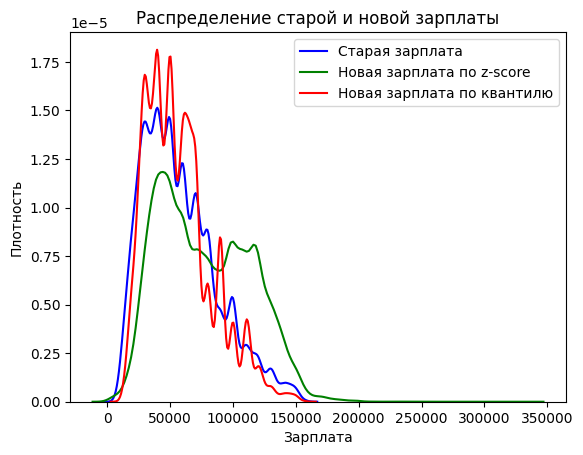

Размер датафрейма (65700, 134), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_27.csv


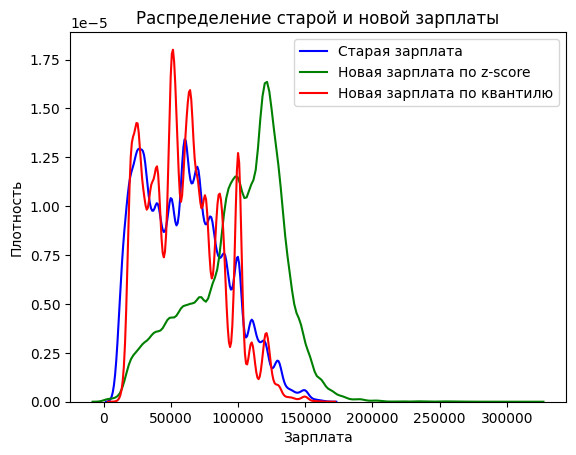

Размер датафрейма (208118, 130), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_31.csv


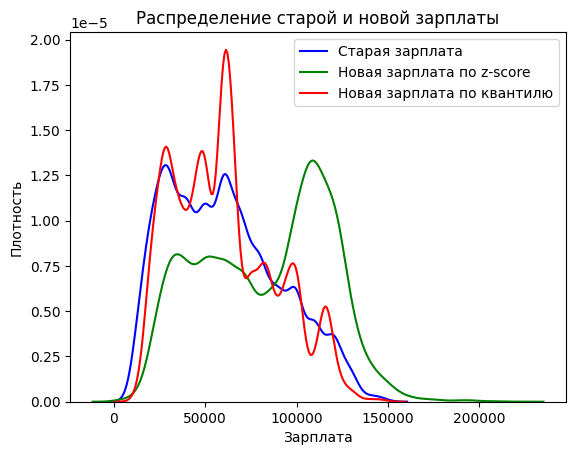

Размер датафрейма (31875, 123), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_33.csv


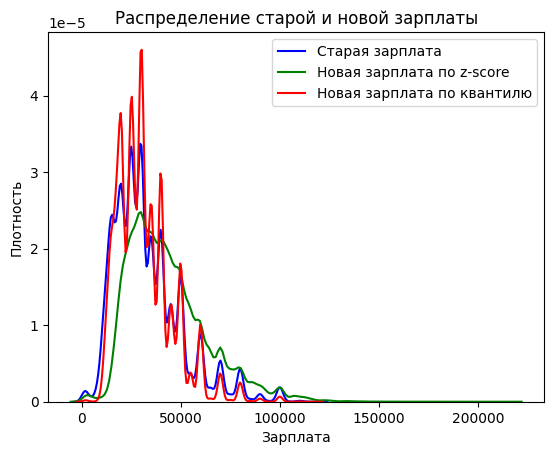

Размер датафрейма (152019, 92), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_49.csv


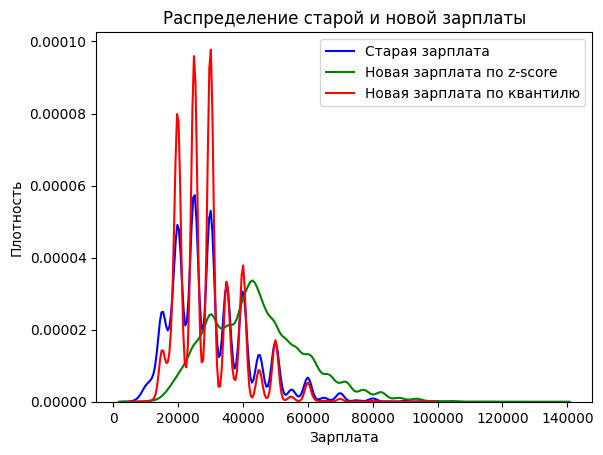

Размер датафрейма (113491, 238), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_52.csv


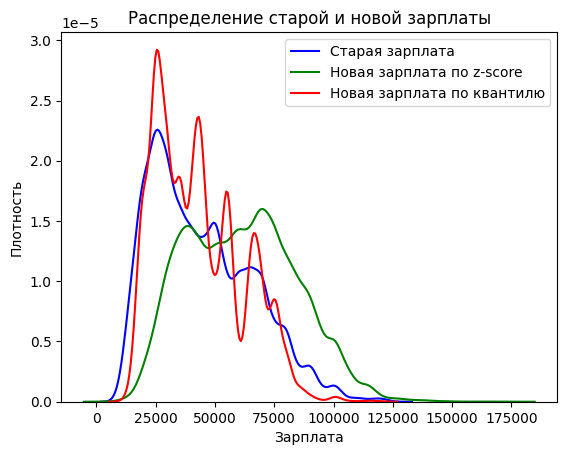

Размер датафрейма (31969, 89), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_54.csv


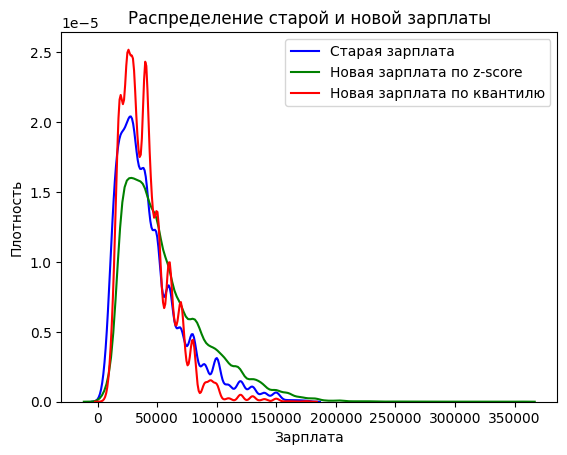

Размер датафрейма (53506, 230), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_58.csv


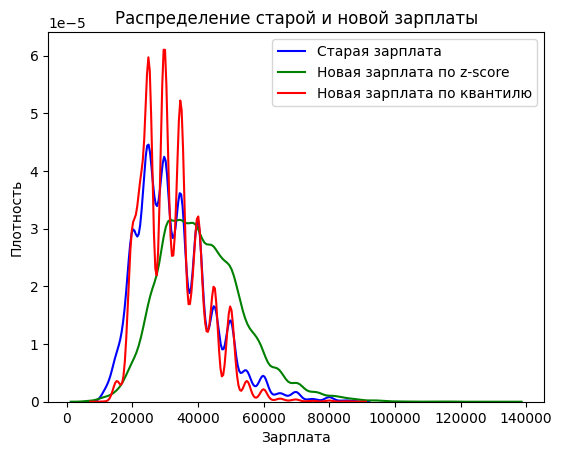

Размер датафрейма (51427, 191), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_61.csv


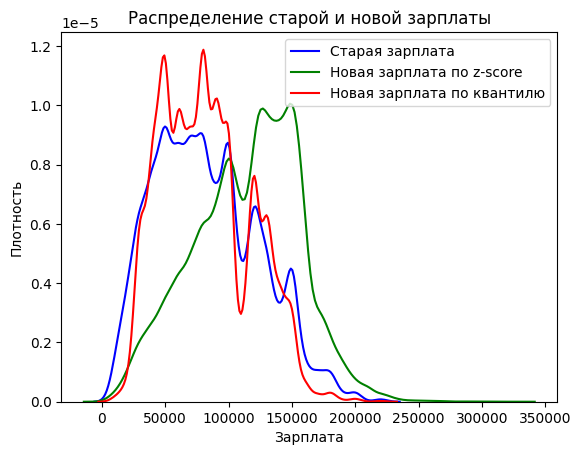

Размер датафрейма (35557, 116), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_69.csv


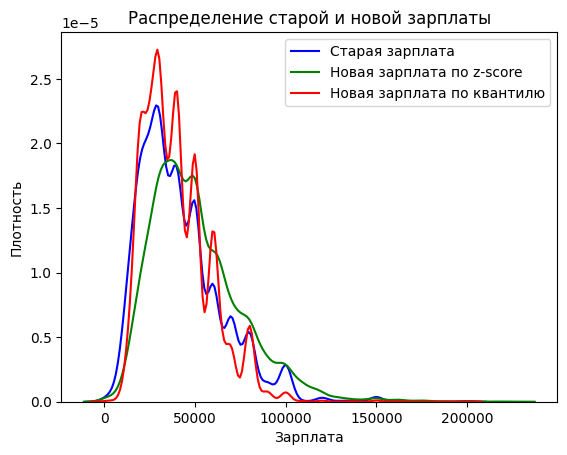

Размер датафрейма (12610, 69), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_74.csv


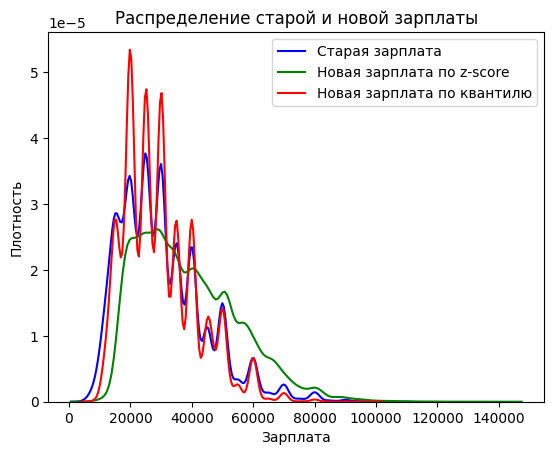

Размер датафрейма (58577, 222), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_91.csv


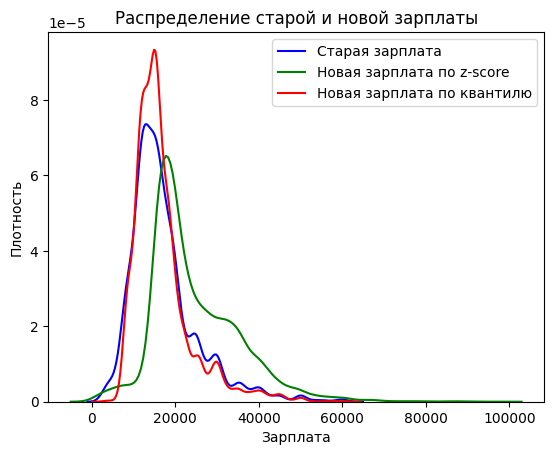

Размер датафрейма (9402, 191), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_116.csv


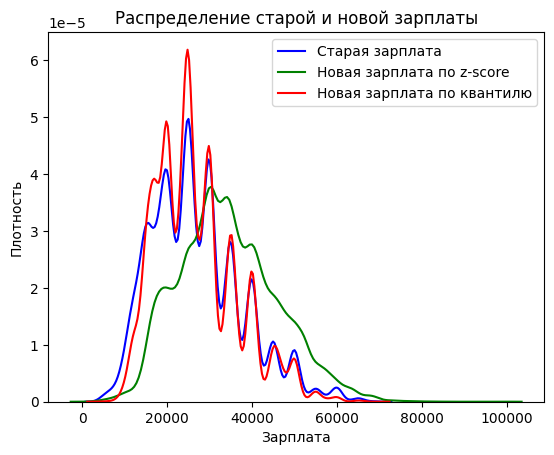

Размер датафрейма (39812, 228), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_119.csv


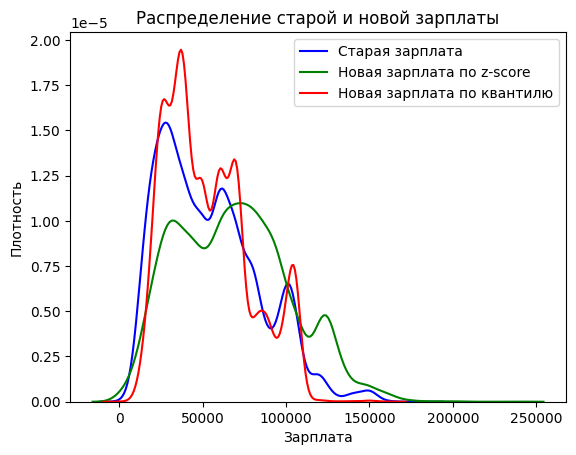

Размер датафрейма (10043, 106), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_128.csv


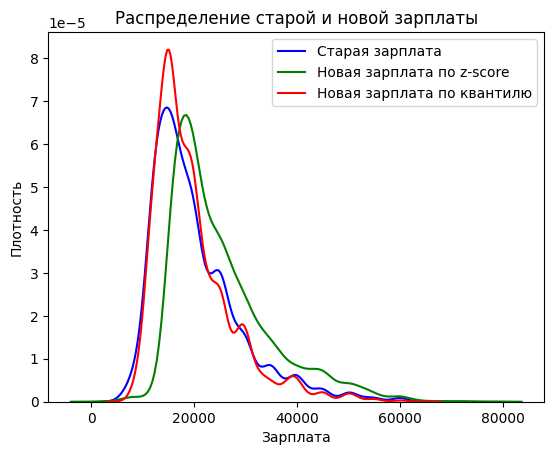

Размер датафрейма (6949, 210), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_134.csv


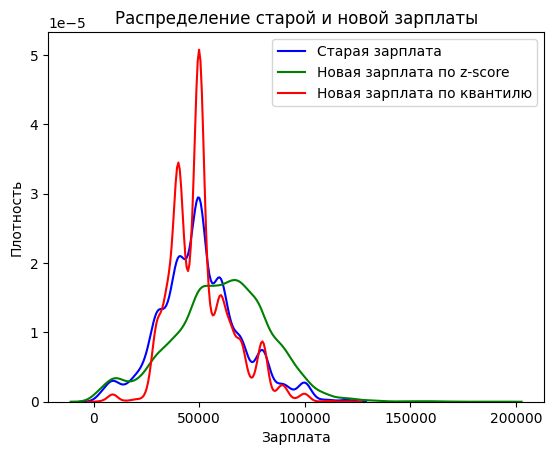

Размер датафрейма (10468, 70), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_283.csv


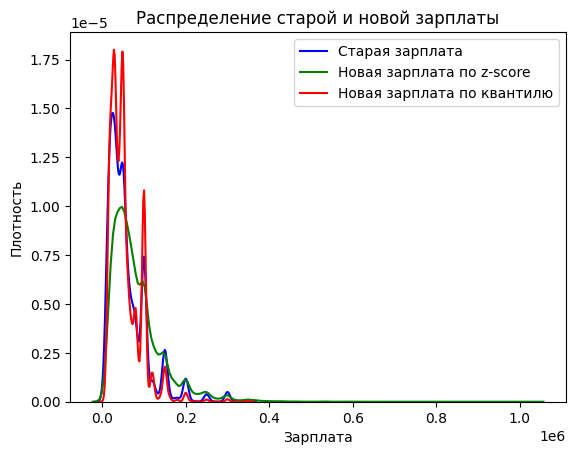

Размер датафрейма (33475, 79), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_336.csv


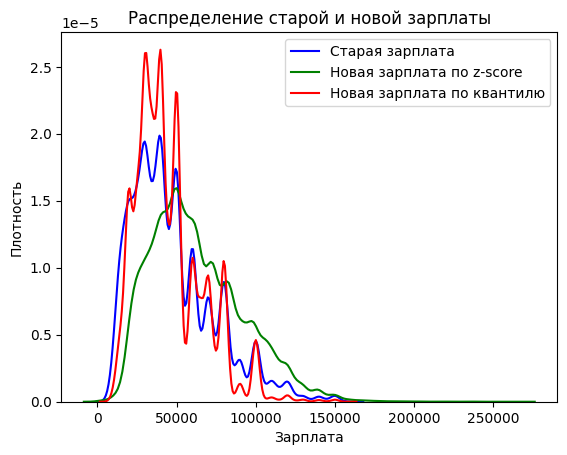

Размер датафрейма (81780, 99), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_663.csv


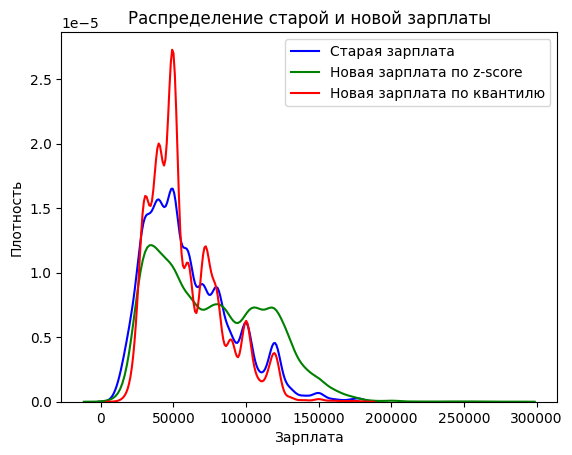

Размер датафрейма (22186, 92), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_706.csv


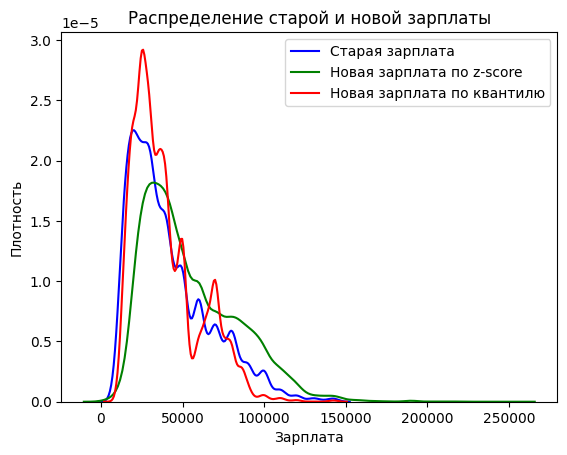

Размер датафрейма (31134, 123), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_767.csv


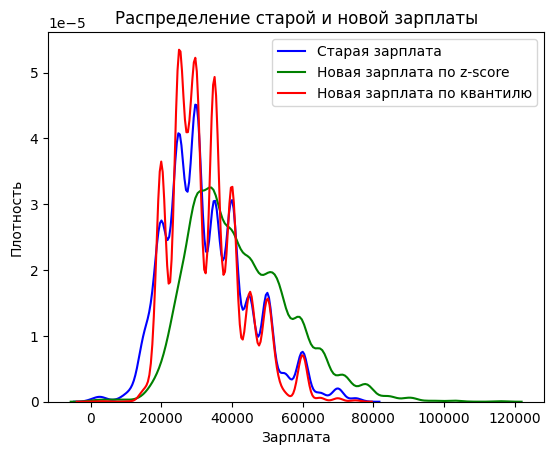

Размер датафрейма (23822, 221), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_783.csv


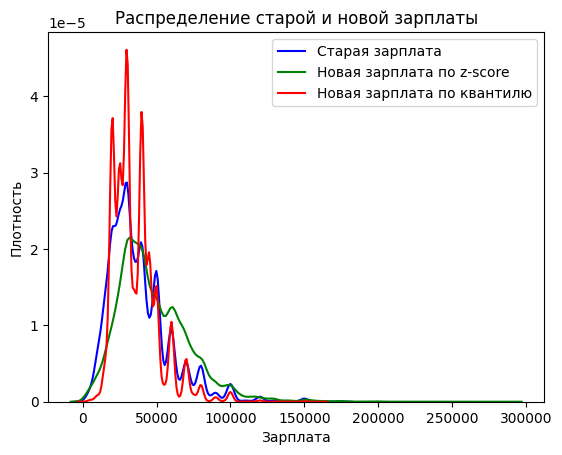

Размер датафрейма (51200, 226), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_833.csv


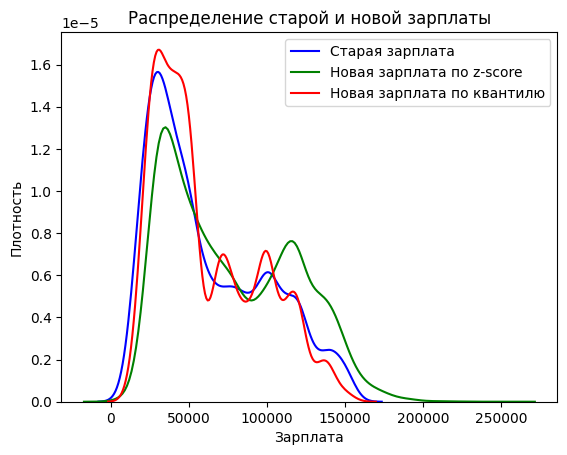

Размер датафрейма (7842, 86), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_919.csv


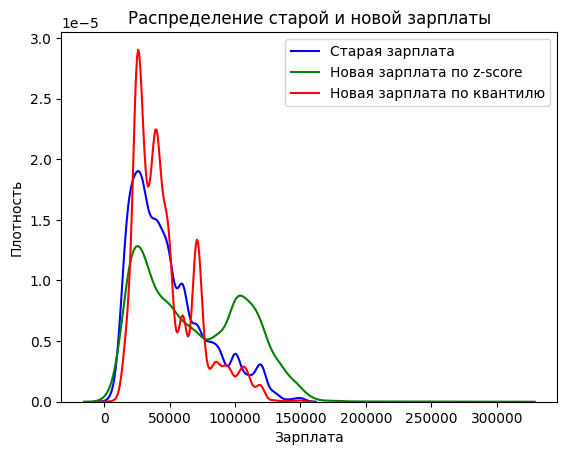

Размер датафрейма (23510, 66), кол-во пропусков 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_836.csv


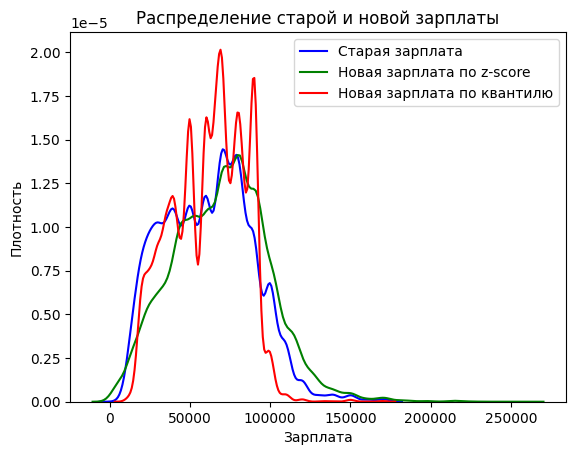

Размер датафрейма (39592, 108), кол-во пропусков 0 и 0
-----------------


In [ ]:
path = '/content/drive/MyDrive/solovey/Bundles2023'
papka_save = '/content/drive/MyDrive/solovey/salary_v2'
files = [i for i in os.listdir(path) if 'Bundles' in i]



# 1 способ) пересчёт зп через z-оценку
def calculate_z_score(df, df2023):
    # val_zp - конкретная зарплата по вакансии до 2023 года
    val_zp = df['salary_from_rub']

    # std1 - стандартное отклонение подвыборки с соц-дем характеристика val_zp и тому же году
    std1 = df['salary_from_rub'].std()

    # std2 - стандартное отклонение подвыборки с соц-дем характеристиками val_zp, но по году 2023
    std2 = df2023['salary_from_rub'].std()

    # mean1 - среднее подвыборки с соц-дем характеристиками val_zp и тому же году
    mean1 = df['salary_from_rub'].mean()
    # mean2 - среднее подвыборки с соц-дем характеристиками val_zp, но по году 2023
    mean2 = df2023['salary_from_rub'].mean()

    z_score = val_zp/std1*std2-mean1/std1*std2+mean2
    return z_score



# 2 способ) Функция для замены зарплаты на ближайшее значение квантиля
def replace_with_nearest_quantile(df, df2023):
    quantiles2023 = df2023['salary_from_rub'].quantile([0.25, 0.5, 0.75])
    quantiles = df['salary_from_rub'].quantile([0.25, 0.5, 0.75])

    distances = np.abs(df['salary_from_rub'].values[:, None] - quantiles.values)
    nearest_quantile_indices = np.argmin(distances, axis=1) # ищем ближайший квантиль для подгруппы (selected_year, region_group, experience)
    nearest_quantiles = quantiles.iloc[nearest_quantile_indices] # заменяю значение val_zp значением ближайшего квентиля для подгруппы (2023 год, region_group, experience)
    return  nearest_quantiles.values


for file in files:
    temp = os.path.join(path, file)
    print(temp)
    df_start = pd.read_csv(temp)
    df = make_df(df_start)

    # пересчёт зп начинается
    new_df = pd.DataFrame()
    experiences = df['experience_id'].unique().tolist()

    groups = sorted(df['group_region'].unique())
    X = 5  # минимальное количество объектов для упрощенной агрегации


    for exp in experiences:
        for index, group in enumerate(groups):
            years = sorted(df.year.unique().tolist())
            for year in years:

                temp_df = df[(df.experience_id == exp) & (df.group_region == group) & (df['year'] == year)]
                temp_df2023 = df[(df.experience_id == exp) & (df.group_region == group) & (df['year'] == 2023)]
                if temp_df.shape[0] == 0:
                    continue

                # если мала размерность temp_df2023
                if temp_df2023.shape[0] < 5:
                    year_counts = {y : temp_df[temp_df['year']==y].shape[0] for y in years}
                    max_year = max(year_counts, key=lambda x: year_counts[x] if year_counts[x] > 5 else -1)
                    if year_counts[max_year] <= 5:
                        max_year = -1

                    if max_year == -1 or max_year<2020:
                        temp_df['new_salary_z_score'] = temp_df['salary_from_rub']
                        temp_df['new_salary_quantile'] = temp_df['salary_from_rub']
                        temp_df2023['new_salary_z_score'] = temp_df2023['salary_from_rub']
                        temp_df2023['new_salary_quantile'] = temp_df2023['salary_from_rub']
                        new_df = new_df.append(temp_df)
                        new_df = new_df.append(temp_df2023)
                        continue

                    else:
                        temp_df2023 = df[(df.experience_id == exp) & (df.group_region == group) & (df['year'] == max_year)]

                        # значения зарплат в temp_df для df['year'] > max_year остаются прежними
                        temp_df[temp_df['year']>=max_year]['new_salary_z_score'] = temp_df[temp_df['year']>=max_year]['salary_from_rub']
                        temp_df[temp_df['year']>=max_year]['new_salary_quantile'] = temp_df[temp_df['year']>=max_year]['salary_from_rub']
                        new_df = new_df.append(temp_df)

                        temp_df = temp_df[temp_df['year'] < max_year]


                # если мала размерность temp_df, то упрощаем уровень агрегации
                elif temp_df.shape[0] < X:
                    conditions = [(df['year'] == year), (df.group_region == group), (df.experience_id == exp)]
                    while temp_df.shape[0] < X and len(conditions) > 0:
                        condition = conditions.pop(0)
                        if len(conditions) == 2:
                            temp_df = df[condition]
                        else:
                            temp_df = temp_df[condition]


                # тут с размерами подвыборок уже всё хорошо
                temp_df['new_salary_z_score'] = calculate_z_score(temp_df, temp_df2023)
                temp_df['new_salary_quantile'] = replace_with_nearest_quantile(temp_df, temp_df2023)

                new_df = new_df.append(temp_df)
                new_df = new_df.append(temp_df2023)




    # строки, что до этого удаляли возращаем обратно
    deleted_rows = df_start[~df_start.index.isin(new_df.index)]
    new_df = pd.concat([new_df, deleted_rows], ignore_index=True)
    new_df = new_df.drop_duplicates()
    new_df['new_salary_quantile'].fillna(new_df['salary_from_rub'], inplace=True)
    new_df['new_salary_z_score'].fillna(new_df['salary_from_rub'], inplace=True)
    new_df['new_salary_z_score'] = np.where(new_df['new_salary_z_score'] < 0, new_df['salary_from_rub'], new_df['new_salary_z_score'])
    draw_new_zp(new_df)

    print(f"Размер датафрейма {new_df.shape}, кол-во пропусков {new_df['new_salary_z_score'].isnull().sum()} и {new_df['new_salary_quantile'].isnull().sum()}")

    # сохраняем
    #new_df.to_csv(os.path.join(papka_save, file), index=False)
    print('-----------------')







# пункт 5

In [ ]:
# по всем профессиям наблюдается положительный скос распределения
for file in files:
    temp = os.path.join(path, file)
    df = pd.read_csv(temp)
    df = df[(df['salary_from_rub'] < np.quantile(np.array(df['salary_from_rub']),0.998))&(df['salary_from_rub'] > np.quantile(np.array(df['salary_from_rub']),0.002))] # убираем выбросы
    skewness = skew(df['salary_from_rub'])

    # Установка границ отбора на основе скоса
    upper_bound = df['salary_from_rub'].median() + df['salary_from_rub'].std()
    lower_bound = df['salary_from_rub'].median() - df['salary_from_rub'].std()

    # Если скос положителен, увеличиваем верхнюю границу
    if skewness > 0:
        upper_bound += 0.33 * df['salary_from_rub'].std()
    # Если скос отрицателен, уменьшаем верхнюю границу
    elif skewness < 0:
        upper_bound -= 0.33 * df['salary_from_rub'].std()

    print("Верхняя граница отбора:", upper_bound)
    print("Нижняя граница отбора:", lower_bound)
    print('------------------------------------')

Верхняя граница отбора: 88610.95544268977
Нижняя граница отбора: 20969.206434067844
------------------------------------
Верхняя граница отбора: 100778.91672721958
Нижняя граница отбора: 29339.160355473996
------------------------------------
Верхняя граница отбора: 100222.93196519825
Нижняя граница отбора: 29757.194011129137
------------------------------------
Верхняя граница отбора: 51538.576250286445
Нижняя граница отбора: 13805.581766701924
------------------------------------
Верхняя граница отбора: 44382.71769422813
Нижняя граница отбора: 16996.076921632986
------------------------------------
Верхняя граница отбора: 68041.11297666658
Нижняя граница отбора: 18916.456408521368
------------------------------------
Верхняя граница отбора: 72295.0086231749
Нижняя граница отбора: 6958.640132951197
------------------------------------
Верхняя граница отбора: 44681.132951518135
Нижняя граница отбора: 18961.554171790878
------------------------------------
Верхняя граница отбора: 132924

# пункт 6 (квантиль, z-score, коэфициент)

In [ ]:
def draw_new_zp(df):
    old_salaries = df['salary_from_rub']
    new_salaries_z = df['new_salary_z_score']
    new_salaries_q = df['new_salary_quantile']
    new_salaries_coef = df['new_salary_coefficient']


    sns.kdeplot(data=old_salaries, color='blue', label='Старая зарплата')
    sns.kdeplot(data=new_salaries_z, color='green', label='Новая зарплата по z-score')
    sns.kdeplot(data=new_salaries_q, color='red', label='Новая зарплата по квантилю')
    sns.kdeplot(data=new_salaries_coef, color='yellow', label='Новая зарплата по коэффициенту')


    plt.xlabel('Зарплата')
    plt.ylabel('Плотность')
    plt.title('Распределение старой и новой зарплаты')
    plt.legend()
    plt.show()

/content/drive/MyDrive/solovey/Bundles2023/Bundles_16.csv


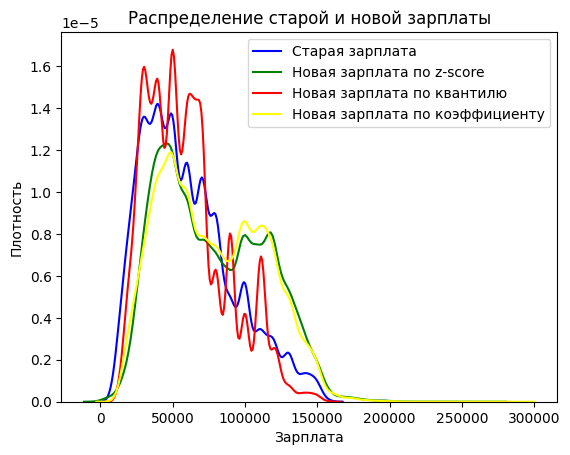

Размер датафрейма (67157, 132), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_27.csv


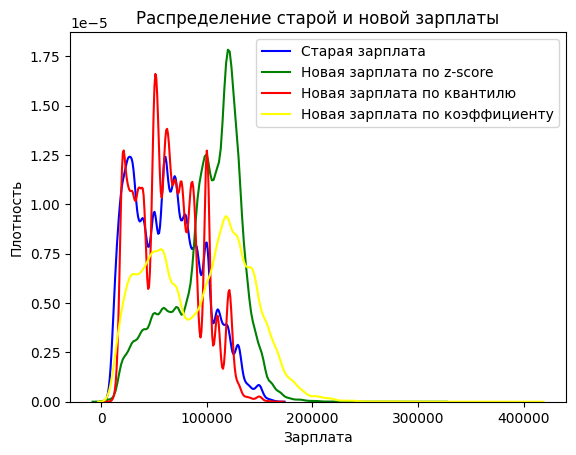

Размер датафрейма (198498, 128), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_31.csv


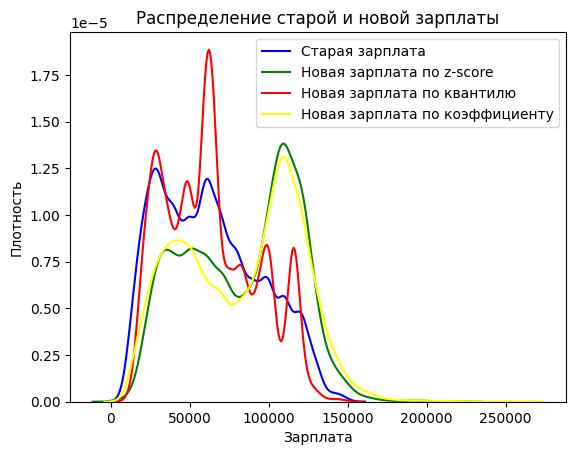

Размер датафрейма (33172, 121), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_33.csv


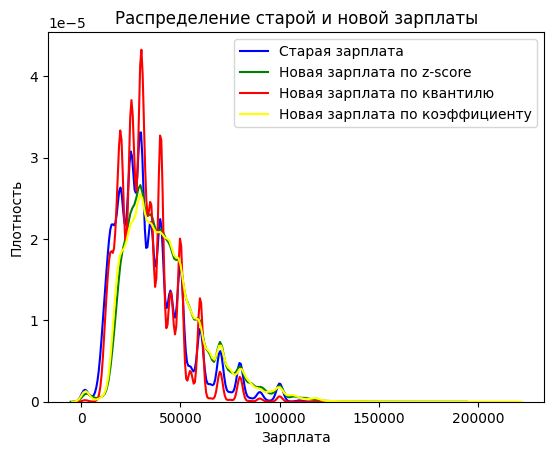

Размер датафрейма (151014, 92), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_49.csv


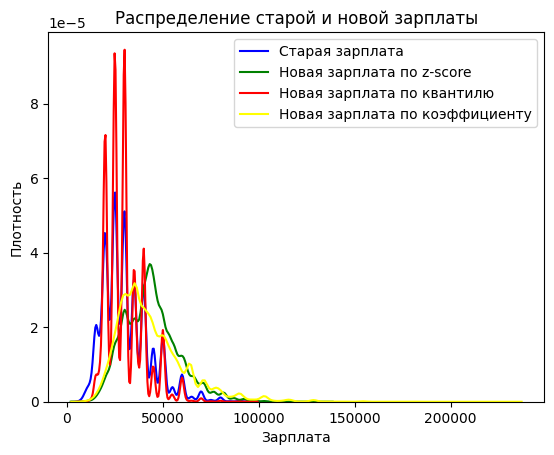

Размер датафрейма (106285, 237), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_52.csv


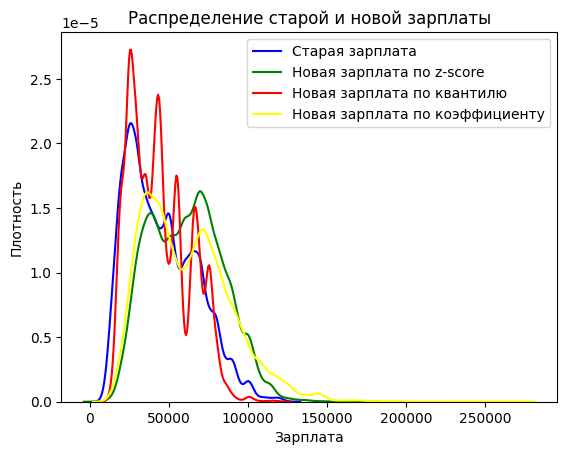

Размер датафрейма (33437, 89), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_54.csv


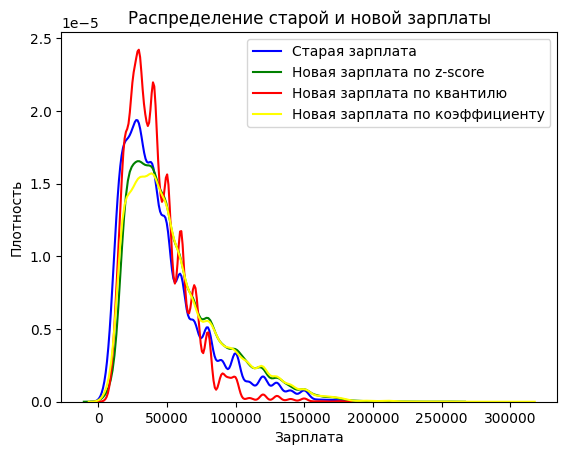

Размер датафрейма (52492, 228), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_58.csv


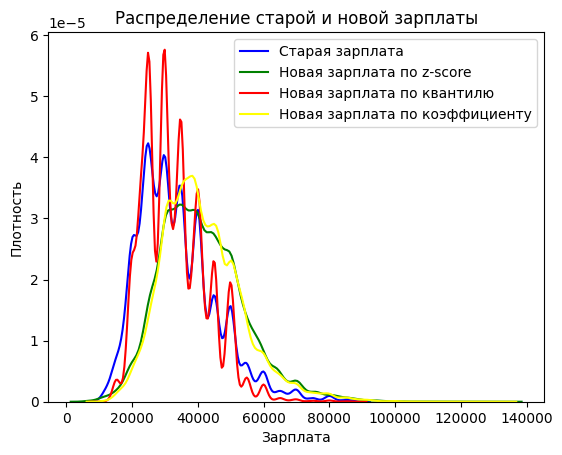

Размер датафрейма (50113, 191), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_61.csv


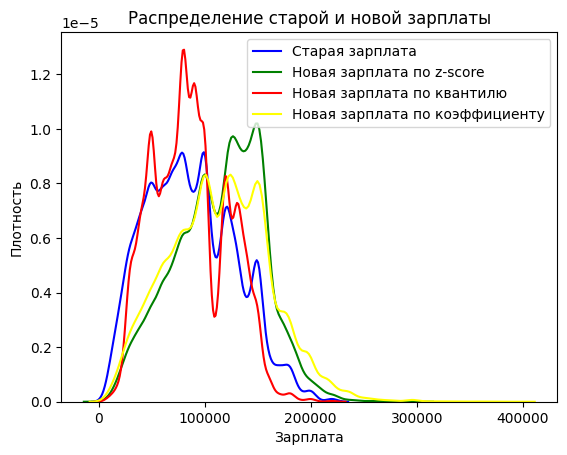

Размер датафрейма (34988, 115), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_69.csv


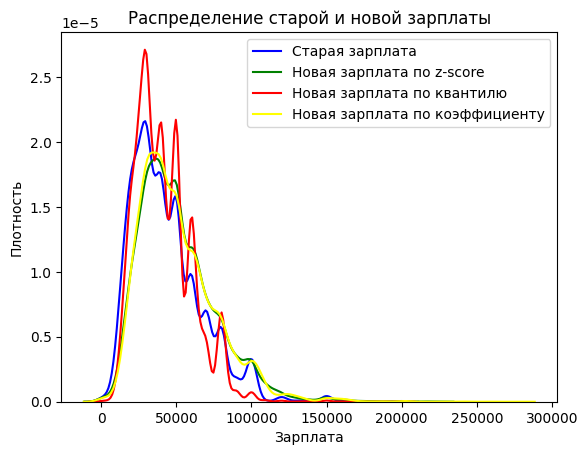

Размер датафрейма (12150, 69), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_74.csv


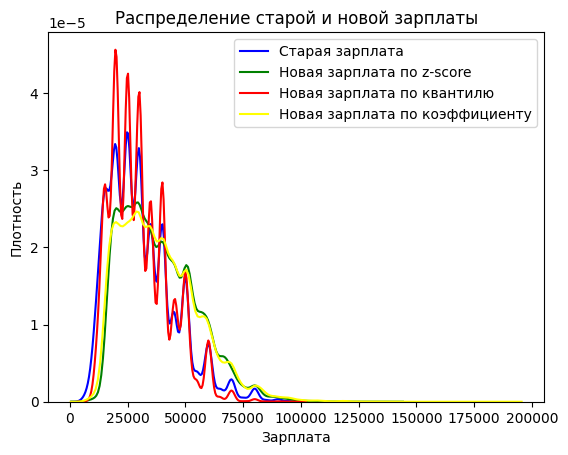

Размер датафрейма (56555, 221), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_91.csv


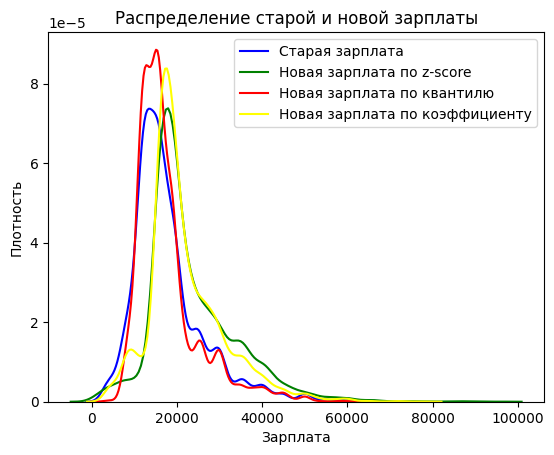

Размер датафрейма (8415, 192), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_116.csv


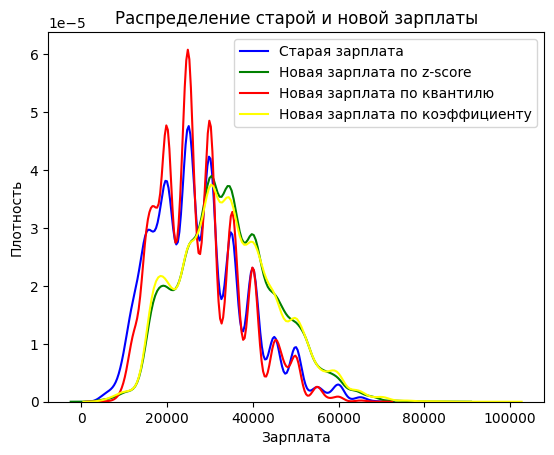

Размер датафрейма (40132, 228), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_119.csv


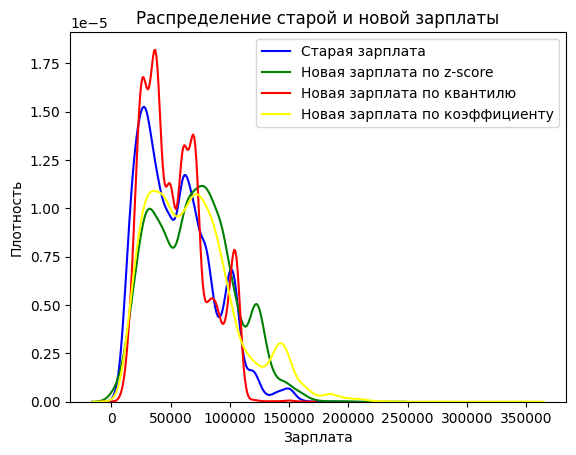

Размер датафрейма (9736, 106), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_128.csv


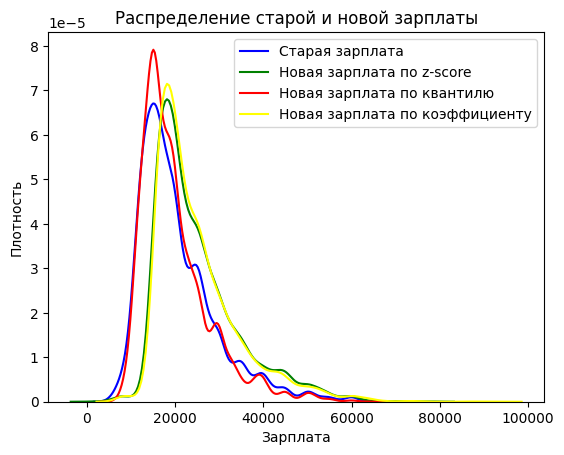

Размер датафрейма (7346, 210), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_134.csv


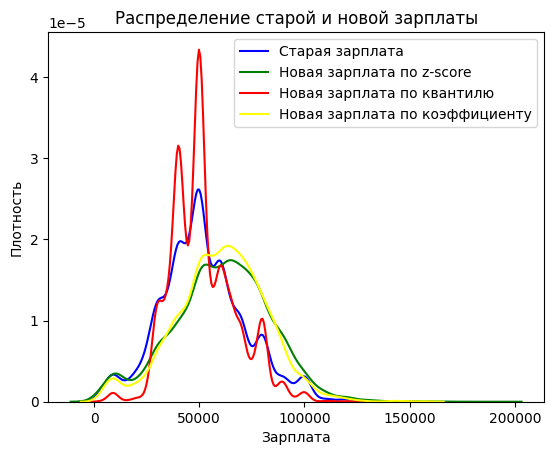

Размер датафрейма (9678, 70), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_283.csv


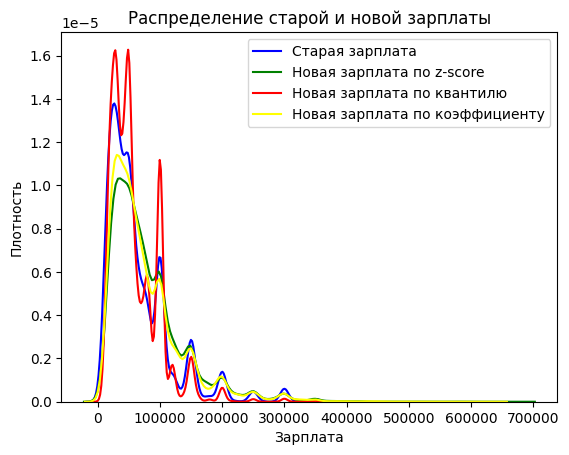

Размер датафрейма (29562, 79), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_336.csv


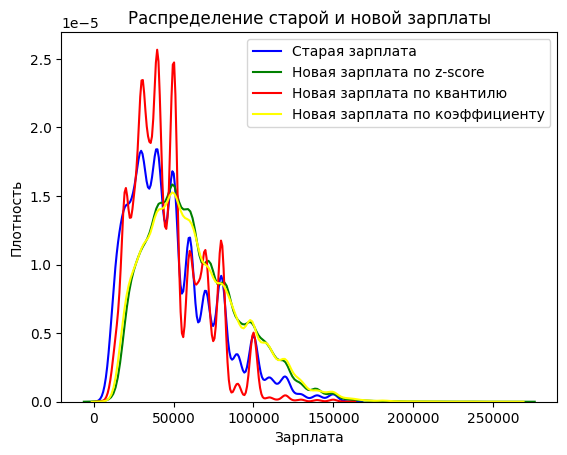

Размер датафрейма (82340, 99), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_663.csv


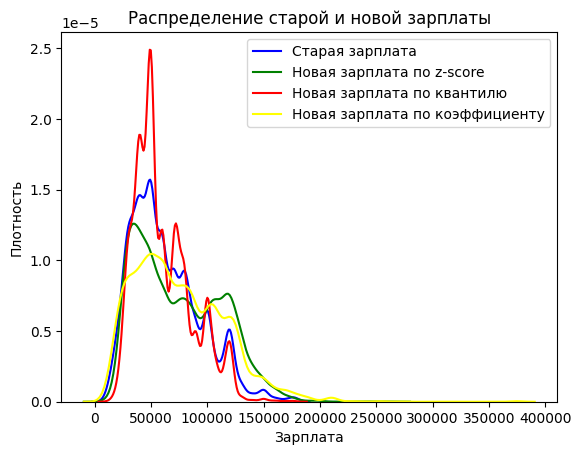

Размер датафрейма (21527, 92), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_706.csv


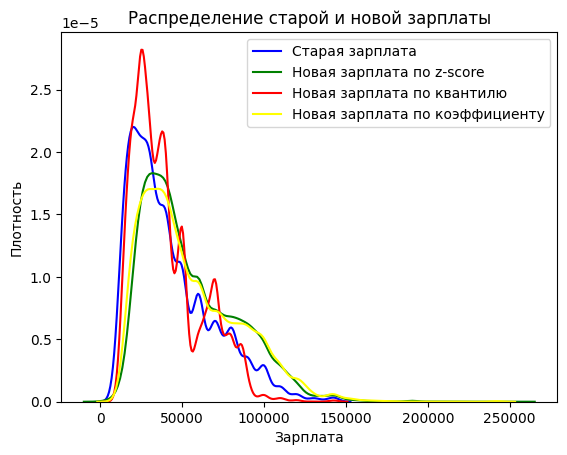

Размер датафрейма (32110, 123), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_767.csv


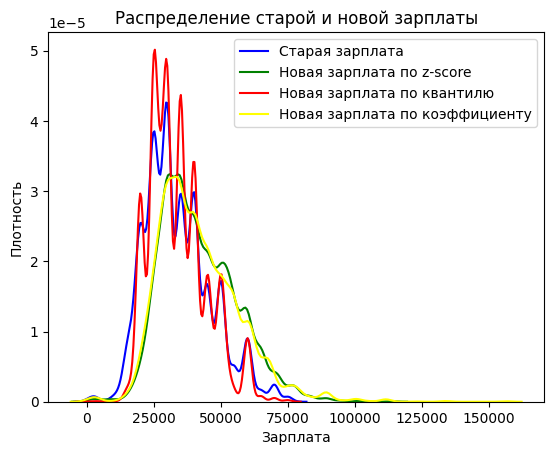

Размер датафрейма (22543, 219), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_783.csv


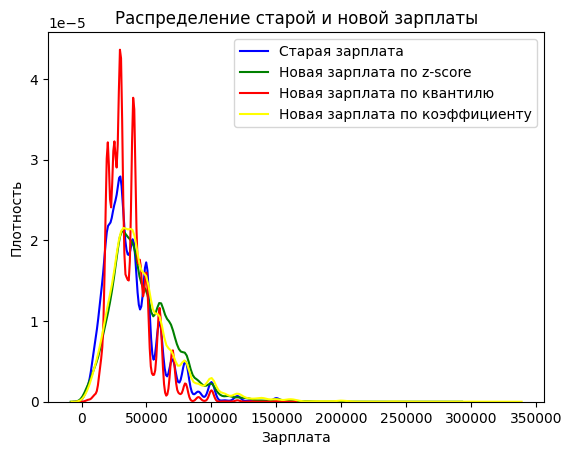

Размер датафрейма (50734, 225), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_833.csv


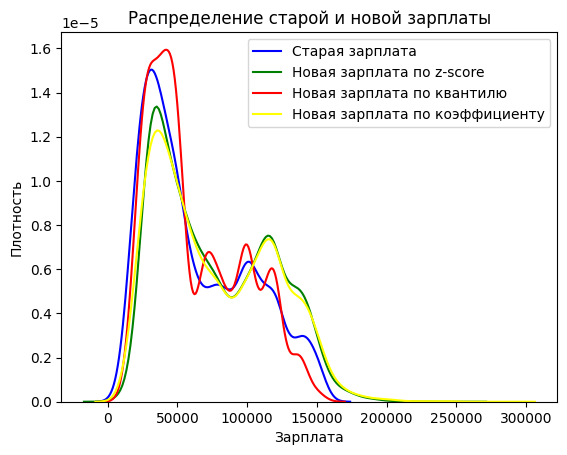

Размер датафрейма (8024, 82), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_836.csv


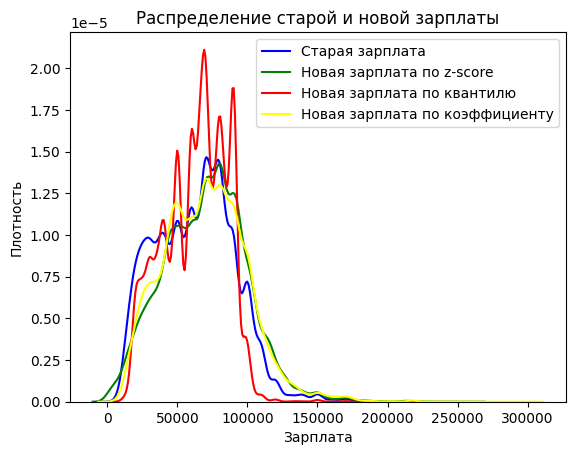

Размер датафрейма (39828, 108), кол-во пропусков 0 и 0 и 0
-----------------
/content/drive/MyDrive/solovey/Bundles2023/Bundles_919.csv


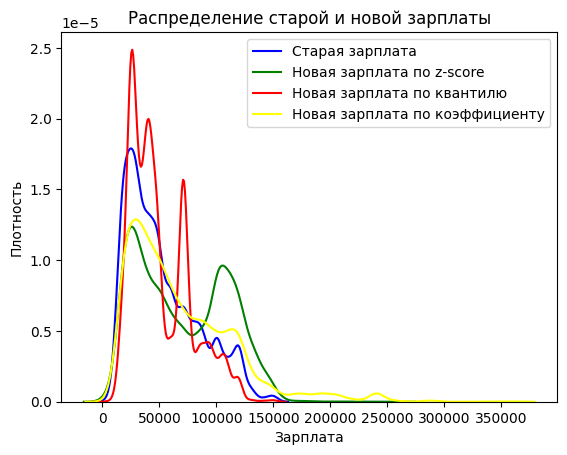

Размер датафрейма (20020, 63), кол-во пропусков 0 и 0 и 0
-----------------


In [ ]:
# попытка
path = '/content/drive/MyDrive/solovey/Bundles2023'
papka_save = '/content/drive/MyDrive/solovey/salary_v2'
files = [i for i in os.listdir(path) if 'Bundles' in i]



# 1 способ) пересчёт зп через z-оценку
def calculate_z_score(df, df2023):
    # val_zp - конкретная зарплата по вакансии до 2023 года
    val_zp = df['salary_from_rub']

    # std1 - стандартное отклонение подвыборки с соц-дем характеристика val_zp и тому же году
    std1 = df['salary_from_rub'].std()

    # std2 - стандартное отклонение подвыборки с соц-дем характеристиками val_zp, но по году 2023
    std2 = df2023['salary_from_rub'].std()

    # mean1 - среднее подвыборки с соц-дем характеристиками val_zp и тому же году
    mean1 = df['salary_from_rub'].mean()
    # mean2 - среднее подвыборки с соц-дем характеристиками val_zp, но по году 2023
    mean2 = df2023['salary_from_rub'].mean()

    z_score = val_zp/std1*std2-mean1/std1*std2+mean2
    return z_score



# 2 способ) Функция для замены зарплаты на ближайшее значение квантиля
def replace_with_nearest_quantile(df, df2023):
    quantiles2023 = df2023['salary_from_rub'].quantile([0.25, 0.5, 0.75])
    quantiles = df['salary_from_rub'].quantile([0.25, 0.5, 0.75])

    distances = np.abs(df['salary_from_rub'].values[:, None] - quantiles.values)
    nearest_quantile_indices = np.argmin(distances, axis=1) # ищем ближайший квантиль для подгруппы (selected_year, region_group, experience)
    nearest_quantiles = quantiles.iloc[nearest_quantile_indices] # заменяю значение val_zp значением ближайшего квентиля для подгруппы (2023 год, region_group, experience)
    return  nearest_quantiles.values


for file in files:
    temp = os.path.join(path, file)
    print(temp)
    df_start = pd.read_csv(temp)
    df = make_df(df_start)

    # пересчёт зп начинается
    new_df = pd.DataFrame()
    experiences = df['experience_id'].unique().tolist()

    groups = sorted(df['group_region'].unique())
    X = 5  # минимальное количество объектов для упрощенной агрегации


    for exp in experiences:
        for index, group in enumerate(groups):
            years = sorted(df.year.unique().tolist())
            for year in years:

                temp_df = df[(df.experience_id == exp) & (df.group_region == group) & (df['year'] == year)]
                temp_df2023 = df[(df.experience_id == exp) & (df.group_region == group) & (df['year'] == 2023)]
                if temp_df.shape[0] == 0:
                    continue

                # если мала размерность temp_df2023
                if temp_df2023.shape[0] < 5:
                    year_counts = {y : temp_df[temp_df['year']==y].shape[0] for y in years}
                    max_year = max(year_counts, key=lambda x: year_counts[x] if year_counts[x] > 5 else -1)
                    if year_counts[max_year] <= 5:
                        max_year = -1

                    if max_year == -1 or max_year<2020:
                        temp_df['new_salary_z_score'] = temp_df['salary_from_rub']
                        temp_df['new_salary_quantile'] = temp_df['salary_from_rub']
                        temp_df['new_salary_coefficient'] = temp_df['salary_from_rub']
                        temp_df2023['new_salary_z_score'] = temp_df2023['salary_from_rub']
                        temp_df2023['new_salary_quantile'] = temp_df2023['salary_from_rub']
                        temp_df2023['new_salary_coefficient'] = temp_df2023['salary_from_rub']
                        new_df = new_df.append(temp_df)
                        new_df = new_df.append(temp_df2023)
                        continue

                    else:
                        temp_df2023 = df[(df.experience_id == exp) & (df.group_region == group) & (df['year'] == max_year)]

                        # значения зарплат в temp_df для df['year'] > max_year остаются прежними
                        temp_df[temp_df['year']>=max_year]['new_salary_z_score'] = temp_df[temp_df['year']>=max_year]['salary_from_rub']
                        temp_df[temp_df['year']>=max_year]['new_salary_quantile'] = temp_df[temp_df['year']>=max_year]['salary_from_rub']
                        new_df = new_df.append(temp_df)

                        temp_df = temp_df[temp_df['year'] < max_year]


                # если мала размерность temp_df, то упрощаем уровень агрегации
                elif temp_df.shape[0] < X:
                    conditions = [(df['year'] == year), (df.group_region == group), (df.experience_id == exp)]
                    while temp_df.shape[0] < X and len(conditions) > 0:
                        condition = conditions.pop(0)
                        if len(conditions) == 2:
                            temp_df = df[condition]
                        else:
                            temp_df = temp_df[condition]


                # тут с размерами подвыборок уже всё хорошо
                temp_df['new_salary_z_score'] = calculate_z_score(temp_df, temp_df2023)
                temp_df['new_salary_quantile'] = replace_with_nearest_quantile(temp_df, temp_df2023)

                # с помощью коэфициента считаем
                mean_2023 = temp_df2023['salary_from_rub'].mean()
                mean_selected_year = temp_df['salary_from_rub'].mean()
                coefficient = mean_2023 / mean_selected_year
                if np.isnan(coefficient) or coefficient > 3 or coefficient < 0.33:
                    temp_df['new_salary_coefficient'] = None
                    new_df = new_df.append(temp_df)
                    continue

                temp_df['new_salary_coefficient'] = temp_df['salary_from_rub'] * coefficient
                new_df = new_df.append(temp_df)
                new_df = new_df.append(temp_df2023)




    # строки, что до этого удаляли возращаем обратно
    deleted_rows = df_start[~df_start.index.isin(new_df.index)]
    new_df = pd.concat([new_df, deleted_rows], ignore_index=True)
    new_df = new_df.drop_duplicates()
    new_df['new_salary_quantile'].fillna(new_df['salary_from_rub'], inplace=True)
    new_df['new_salary_z_score'].fillna(new_df['salary_from_rub'], inplace=True)
    new_df['new_salary_coefficient'].fillna(new_df['salary_from_rub'], inplace=True)

    new_df['new_salary_z_score'] = np.where(new_df['new_salary_z_score'] < 0, new_df['salary_from_rub'], new_df['new_salary_z_score'])
    draw_new_zp(new_df)

    print(f"Размер датафрейма {new_df.shape}, кол-во пропусков {new_df['new_salary_coefficient'].isnull().sum()} и {new_df['new_salary_z_score'].isnull().sum()} и {new_df['new_salary_quantile'].isnull().sum()}")

    # сохраняем
    #new_df.to_csv(os.path.join(papka_save, file), index=False)
    print('-----------------')



